# Lab 6: Convolutional Neural Networks

### Katherine Wirskye, Lucas Li, Ethan Li, and Kaylie Nguyen (5000-level students)

Link to dataset: **insert this shi**

## Preparation

In [22]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # so that I don't use GPU
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU') # Disable all GPUs

import numpy as np
import matplotlib.pylab as plt

#import pandas as pd
# from tensorflow import keras

from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import LabelEncoder
from keras.utils import to_categorical

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import Model
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import accuracy_score
# from tensorflow.keras.preprocessing import image
# from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
# from PIL import Image
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# from keras.regularizers import l2

from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomTranslation, RandomZoom

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

In [2]:
# locate directories
folder = "allimages"

image_directories = [
    os.path.join(folder, "angry"),
    os.path.join(folder, "disgust"),
    os.path.join(folder, "fear"),
    os.path.join(folder, "happy"),
    os.path.join(folder, "neutral"),
    os.path.join(folder, "sad"),
    os.path.join(folder, "surprise")
]

# function to get image paths and the emotion label
def get_image_paths_and_labels(image_directories):
    image_paths = [] #stores image paths
    labels = [] #stores labels

    # goes through each of the 7 directories 
    for i, directory in enumerate(image_directories):
        emotion_label = os.path.basename(directory) # captures the emotion label
        # goes through each image in each directory
        for filename in os.listdir(directory):
            if filename.endswith(".jpg") or filename.endswith(".png"):
                image_paths.append(os.path.join(directory, filename)) #appends image path to list
                labels.append(emotion_label) # appends emotion label to list

    return image_paths, labels

# gets image path and label for training and testing set
image_paths, image_labels = get_image_paths_and_labels(image_directories)

print("Number of images:", len(image_paths))
print("Number of labels:", len(image_labels))

Number of images: 35685
Number of labels: 35685


In [11]:
def load_and_preprocess_images(image_paths, img_width, img_height):
    images = []
    for img_path in image_paths:
        img = load_img(img_path, target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_array /= 255.0 # added this normalization
        images.append(img_array)
    return np.array(images)

img_width = 48
img_height = 48

X = load_and_preprocess_images(image_paths, img_width, img_height)

label_encoder = LabelEncoder()

# Fit and transform the labels for training data
labels_encoded = label_encoder.fit_transform(image_labels)

# Convert the encoded labels to one-hot encoded vectors
y = to_categorical(labels_encoded)

print(len(X), len(y))

35685 35685


### Performance Metric

**discuss choice here**

### Data Splitting Method

**discuss choice here**

In [12]:
# define the 5-fold stratified cross validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

# we can probably changes this to 10 later (10 is probably better for statistical test)

## Modeling

### Data Expansion

I think we're just gonna add the layers actually in the models. I've added some layers for the first one. So we can just talk about the data expansion here :D

So far, we have:
- random horizontal flip
- random rotation
- random translation
- random zoom

*Setup the training to use data expansion in Keras (also called data augmentation). 
Explain why the chosen data expansion techniques are appropriate for your dataset. 
You should make use of Keras augmentation layers, like in the class examples.*

### Model 1

*just for my reference, we can condense this later lol (from ChatGPT obv*)

This Convolutional Neural Network (CNN) is designed for multi-class image classification, specifically targeting 7 distinct categories. The architecture begins with data augmentation layers to improve generalization and robustness. These augmentations, including random horizontal flips, rotations (±10%), translations, and zooms, simulate real-world variations in the input data, helping the model learn to handle diverse scenarios. The augmented data is then processed through a sequence of convolutional layers that progressively extract hierarchical features. The initial convolutional layers use 64 filters with 3×3 kernels to capture low-level features such as edges, followed by max-pooling to downsample and batch normalization to stabilize training. As the layers progress, the filter count increases to 128 and then 256, enabling the model to recognize more complex patterns and abstract features, while additional max-pooling reduces spatial dimensions to make the data manageable for the fully connected layers.

Once the convolutional layers have extracted meaningful features, the model transitions to the dense layers for decision-making. The flattening layer converts the 2D feature maps into a 1D vector, which is then passed through a series of dense layers with 1024, 512, and 128 neurons. Each dense layer refines the feature representations, with ReLU activations introducing non-linearity. Dropout layers are incorporated between the dense layers, with 50% and 25% dropout rates, to reduce overfitting by preventing the model from relying too heavily on specific neurons. The final output layer has 7 neurons with a softmax activation function, generating probabilities for each class, ensuring the outputs sum to 1.

To optimize training, the model uses the Adam optimizer, which adapts the learning rate dynamically, and the categorical cross-entropy loss function, ideal for multi-class classification tasks. Accuracy is tracked as the primary metric during training and evaluation. Regularization techniques like batch normalization and dropout, combined with the augmentation strategies, mitigate overfitting and enhance the model’s ability to generalize to unseen data. This comprehensive architecture enables the CNN to effectively extract, abstract, and classify features, aiming to achieve high accuracy in both training and deployment.

In [14]:
# for tracking performance
training_results_model1_1 = []
testing_results_model1_1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    # Kaylie's code yay!
    # build a model
    input_shape = (img_width, img_height, 3)

    model1_1 = Sequential([

        # data expansion and augmentation (should be talked abt previously)
        # these might be decreasing accuracy (I don't know if they're contradicting the pre processing Kaylie did)
        # need to discuss this ^^
        RandomFlip("horizontal"),
        RandomRotation(0.10),
        RandomTranslation(height_factor=0.1, width_factor=0.1),
        RandomZoom(height_factor=0.1, width_factor=0.1),

        # Kaylie's model
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu', input_shape=input_shape),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=64, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        BatchNormalization(),
        Conv2D(filters=128, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        Conv2D(filters=256, kernel_size=3, strides=(1, 1), padding='valid', activation='relu'),
        MaxPooling2D(pool_size=(2, 2), strides=2),
        Flatten(),
        Dense(1024, activation = 'relu'),
        Dense(512, activation = 'relu'),
        Dropout(0.5),
        Dense(128, activation='relu'),
        Dropout(0.25),
        Dense(7, activation='softmax')
    ])

    epochs = 20
    batch_size = 64

    model1_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # traing the model
    history = model1_1.fit(X_train_split, y_train_split, epochs=epochs, batch_size=batch_size, validation_data=(X_val, y_val))
    # add verbose = 0 later!!

    # track accuracy and loss for training data and validation data
    training_results_model1_1.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # evaluate the model on the test data
    test_loss, test_accuracy = model1_1.evaluate(X_test, y_test)
    # add verbose = 0 later!!

    # remove the print statements later
    # we won't want them when we run 10 times
    print('Test Loss: ', test_loss)
    print("Test Accuracy:", test_accuracy)

    testing_results_model1_1.append(test_accuracy)

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

Epoch 1/20
357/357 [==============================] - 35s 95ms/step - loss: 1.8162 - accuracy: 0.2499 - val_loss: 1.7963 - val_accuracy: 0.2545
Epoch 2/20
357/357 [==============================] - 34s 94ms/step - loss: 1.7016 - accuracy: 0.3152 - val_loss: 1.5911 - val_accuracy: 0.3644
Epoch 3/20
357/357 [==============================] - 37s 103ms/step - loss: 1.6140 - accuracy: 0.3556 - val_loss: 1.7398 - val_accuracy: 0.2576
Epoch 4/20
357/357 [==============================] - 42s 119ms/step - loss: 1.5540 - accuracy: 0.3896 - val_loss: 1.5039 - val_accuracy: 0.4299
Epoch 5/20
357/357 [==============================] - 38s 106ms/step - loss: 1.5079 - accuracy: 0.4143 - val_loss: 1.3837 - val_accuracy: 0.4673
Epoch 6/20
357/357 [==============================] - 37s 103ms/step - loss: 1.4629 - accuracy: 0.4309 - val_loss: 1.4617 - val_accuracy: 0.4247
Epoch 7/20
357/357 [==============================] - 37s 104ms/step - loss: 1.4387 - accuracy: 0.4475 - val_loss: 1.3855 - val_accu

##### Loss Across Training Iterations

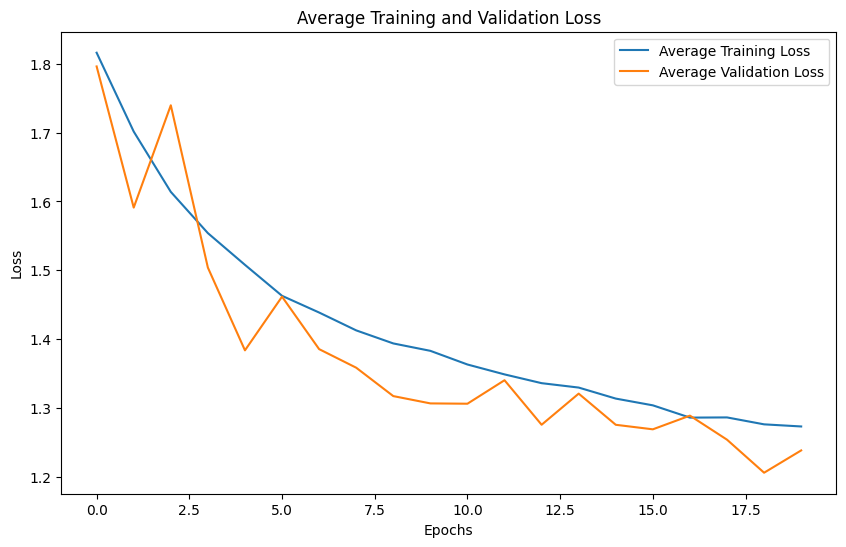

In [15]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model1_1[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss1_1 = []
avg_val_loss1_1 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model1_1]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model1_1]
    
    avg_loss1_1.append(np.mean(epoch_loss))
    avg_val_loss1_1.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss1_1, label='Average Training Loss')
plt.plot(avg_val_loss1_1, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

##### Performance Across Training Iterations

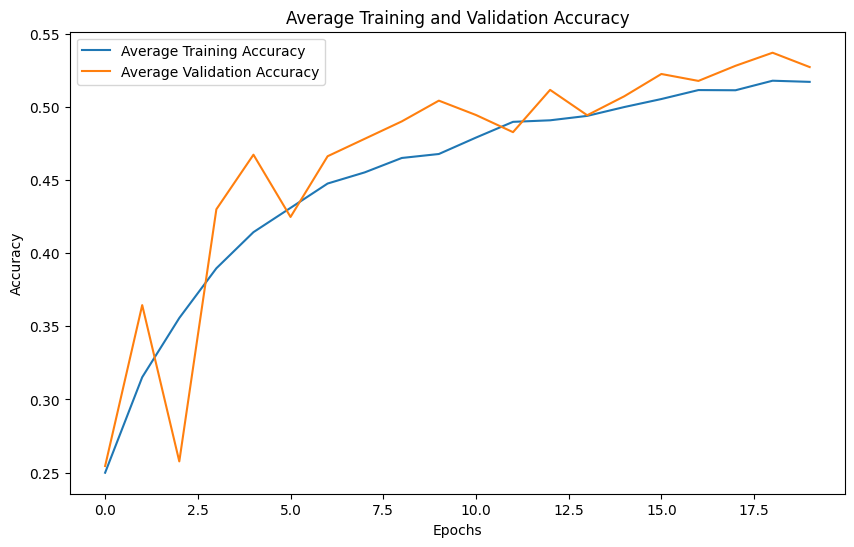

In [16]:
# Initialize lists to store the average accuracy and validation accuracy across all instances
avg_accuracy1_1 = []
avg_val_accuracy1_1 = []

# Calculate the average accuracy and validation accuracy for each epoch
for epoch in range(num_epochs):
    epoch_accuracy = [result['accuracy'][epoch] for result in training_results_model1_1]
    epoch_val_accuracy = [result['val_accuracy'][epoch] for result in training_results_model1_1]
    
    avg_accuracy1_1.append(np.mean(epoch_accuracy))
    avg_val_accuracy1_1.append(np.mean(epoch_val_accuracy))

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_accuracy1_1, label='Average Training Accuracy')
plt.plot(avg_val_accuracy1_1, label='Average Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()
plt.show()

##### Testing Performance

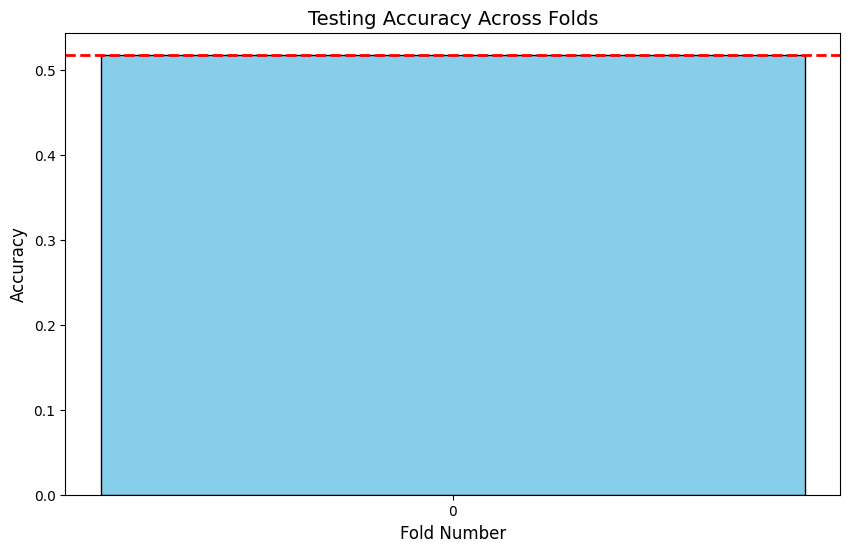

Average Accuracy:  0.5177245140075684
Standard Deviation:  0.0


In [17]:
# Calculate the average tseting accuracy
average1_1 = np.mean(testing_results_model1_1)
std1_1 = np.std(testing_results_model1_1)

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(range(len(testing_results_model1_1)), testing_results_model1_1, color='skyblue', edgecolor='black', label='Values')

# Plot the average as a horizontal line
plt.axhline(average1_1, color='red', linestyle='--', linewidth=2, label=f'Average ({average1_1:.4f})')

# Add labels and title
plt.xlabel('Fold Number', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.title('Testing Accuracy Across Folds', fontsize=14)
plt.xticks(range(len(testing_results_model1_1)))

# Show the plot
plt.show()

# Print average and standard deviation for accuracy
print("Average Accuracy: ", average1_1)
print("Standard Deviation: " , std1_1)

#### Model 1 with Changed Parameters

### Model 2 (Trying Larson's with the same parameters)

In [18]:
# for tracking performance
training_results_model2_1 = []
testing_results_model2_1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    ### REPLACE THIS    
    # changes: 
    #    1. Baseline: 2 conv layers and two output layers
    cnn1 = Sequential()

    # data augmentation 
    cnn1.add(RandomFlip("horizontal"))
    cnn1.add(RandomRotation(0.10))
    cnn1.add(RandomTranslation(height_factor=0.1, width_factor=0.1))
    cnn1.add(RandomZoom(height_factor=0.1, width_factor=0.1))

    num_filt_layers = [24, 24]
    for num_filters in num_filt_layers:
        cnn1.add( Conv2D(filters=num_filters, 
                        kernel_size=(3,3), 
                        padding='same') )
        cnn1.add( Activation('relu'))
        cnn1.add( MaxPooling2D(pool_size=(2, 2), 
                            ) )
        

    # add one layer on flattened output
    cnn1.add( Flatten() )
    cnn1.add( Dense(1024, activation='relu') )
    cnn1.add( Dense(512, activation='relu') )
    cnn1.add( Dense(128, activation='relu') )
    cnn1.add( Dense(7, activation='softmax') )

    # Let's train the model 
    cnn1.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    input_shape = [None, 48,48,3]
    cnn1.build(input_shape)

    # we need to exapnd the dimensions here to give the 
    #   "channels" dimension expected by Keras
    history = cnn1.fit(X_train_split, y_train_split, 
            batch_size=64, epochs=20, 
            shuffle=True, verbose=1,
            validation_data=(X_val,y_val))

    # track accuracy and loss for training data and validation data
    training_results_model2_1.append({
        'loss': history.history['loss'],
        'accuracy': history.history['accuracy'],
        'val_loss': history.history['val_loss'],
        'val_accuracy': history.history['val_accuracy']
    })

    # evaluate the model on the test data
    test_loss, test_accuracy = cnn1.evaluate(X_test, y_test)
    # add verbose = 0 later!!

    # remove the print statements later
    # we won't want them when we run 10 times
    print('Test Loss: ', test_loss)
    print("Test Accuracy:", test_accuracy)

    testing_results_model2_1.append(test_accuracy)

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

Epoch 1/15
357/357 [==============================] - 14s 37ms/step - loss: 1.7860 - accuracy: 0.2592 - val_loss: 1.7542 - val_accuracy: 0.2846
Epoch 2/15
357/357 [==============================] - 13s 37ms/step - loss: 1.7353 - accuracy: 0.2816 - val_loss: 1.7243 - val_accuracy: 0.2939
Epoch 3/15
357/357 [==============================] - 14s 38ms/step - loss: 1.7085 - accuracy: 0.3056 - val_loss: 1.6295 - val_accuracy: 0.3595
Epoch 4/15
357/357 [==============================] - 14s 39ms/step - loss: 1.6547 - accuracy: 0.3373 - val_loss: 1.5601 - val_accuracy: 0.3921
Epoch 5/15
357/357 [==============================] - 14s 39ms/step - loss: 1.6016 - accuracy: 0.3706 - val_loss: 1.4816 - val_accuracy: 0.4315
Epoch 6/15
357/357 [==============================] - 15s 42ms/step - loss: 1.5474 - accuracy: 0.3967 - val_loss: 1.4394 - val_accuracy: 0.4394
Epoch 7/15
357/357 [==============================] - 15s 42ms/step - loss: 1.5193 - accuracy: 0.4063 - val_loss: 1.4380 - val_accuracy:

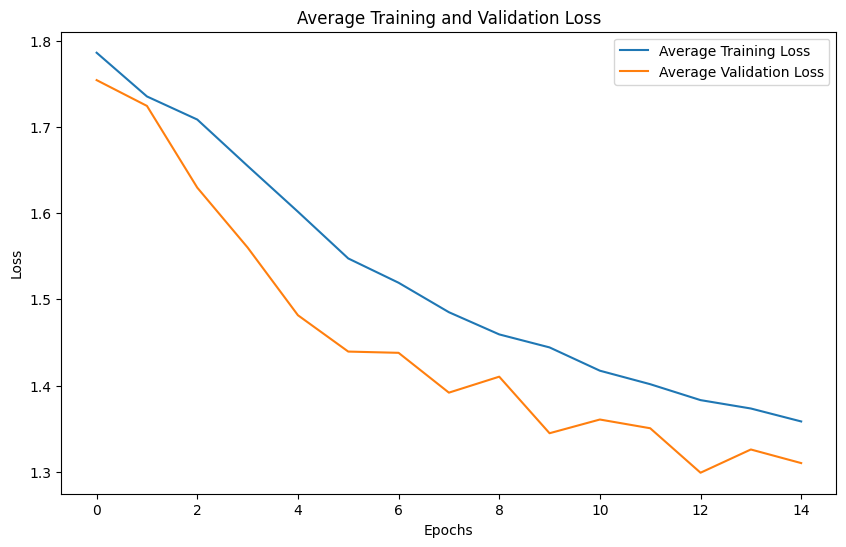

In [19]:
# Get the number of epochs from one of the training histories
num_epochs = len(training_results_model2_1[0]['loss'])

# Initialize lists to store the average loss and validation loss across all instances
avg_loss2_1 = []
avg_val_loss2_1 = []

# Calculate the average loss and validation loss for each epoch
for epoch in range(num_epochs):
    epoch_loss = [result['loss'][epoch] for result in training_results_model2_1]
    epoch_val_loss = [result['val_loss'][epoch] for result in training_results_model2_1]
    
    avg_loss2_1.append(np.mean(epoch_loss))
    avg_val_loss2_1.append(np.mean(epoch_val_loss))

# Plot the average training and validation loss across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_loss2_1, label='Average Training Loss')
plt.plot(avg_val_loss2_1, label='Average Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Average Training and Validation Loss')
plt.legend()
plt.show()

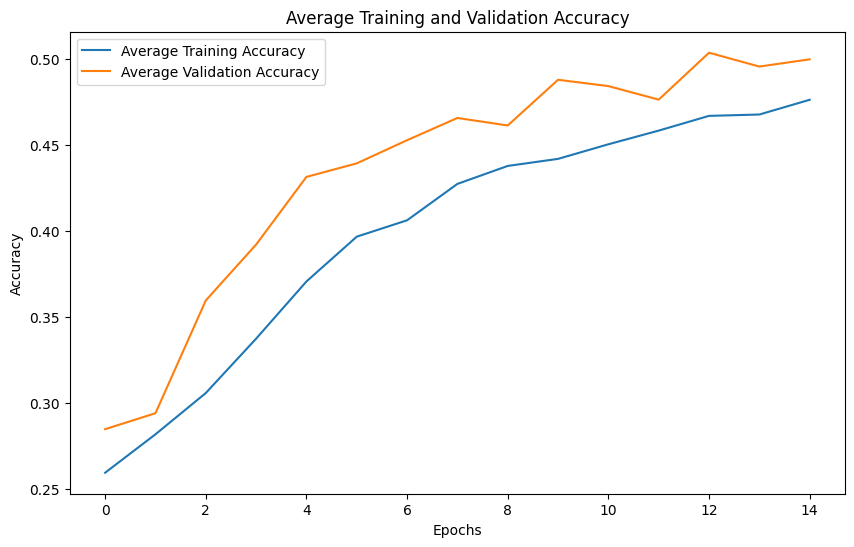

In [20]:
# Initialize lists to store the average accuracy and validation accuracy across all instances
avg_accuracy2_1 = []
avg_val_accuracy2_1 = []

# Calculate the average accuracy and validation accuracy for each epoch
for epoch in range(num_epochs):
    epoch_accuracy = [result['accuracy'][epoch] for result in training_results_model2_1]
    epoch_val_accuracy = [result['val_accuracy'][epoch] for result in training_results_model2_1]
    
    avg_accuracy2_1.append(np.mean(epoch_accuracy))
    avg_val_accuracy2_1.append(np.mean(epoch_val_accuracy))

# Plot the average training and validation accuracy across all instances
plt.figure(figsize=(10, 6))
plt.plot(avg_accuracy2_1, label='Average Training Accuracy')
plt.plot(avg_val_accuracy2_1, label='Average Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Average Training and Validation Accuracy')
plt.legend()
plt.show()

#### Model 2 with Changed Parameters

### Performance Comparison

### MLP Code

In [23]:
# values we need for the plot (we will plot only one of the ten instances of the model)
ex_fpr1 = dict()
ex_tpr1 = dict()
ex_roc_auc1 = dict()
count = 0

# for tracking performance of all 10 splits
micro_aucs1 = []
macro_aucs1 = []

# Using stratified k-fold, we call it like this:
for train_index, test_index in skf.split(X, labels_encoded):
    
    # track the number split we're on, so we can save the data for the first split
    count += 1
    
    # Split the image arrays
    X_train, X_test = X[train_index], X[test_index]
    # Use one-hot encoded labels for the model
    y_train, y_test = y[train_index], y[test_index]

    # Convert one-hot encoded y_train back to categorical labels for stratification
    y_train_categorical = np.argmax(y_train, axis=1)
    # Create a stratified split for validation
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train_categorical, random_state=1)

    ### REPLACE THIS    
    # make a keras MLP
    mlp = Sequential()
    mlp.add( Flatten() )
    mlp.add( Dense(input_dim=1, units=1024, activation='relu') )
    mlp.add( Dense(units=512, activation='relu') )
    mlp.add( Dense(units=128, activation='relu') )
    mlp.add( Dense(7) ) #not sure about this
    mlp.add( Activation('softmax') )

    mlp.compile(loss='categorical_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])

    input_shape = [None, 48,48,3]
    mlp.build(input_shape)

    history = mlp.fit(X_train_split, y_train_split, 
            batch_size=64, epochs=8, 
            shuffle=True, verbose=1)

    # Predict probabilities on the test set (needed for ROC curve)
    y_pred_proba = mlp.predict(X_test, verbose=0)  # This gives predicted probabilities for each class
    y_pred_labels = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class labels

    # find the true labels
    y_true = np.argmax(y_test, axis=1)

    # Calculate ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    n_classes = 7  # Number of classes

    for i in range(n_classes):
        # For each class, calculate the false positive rate (fpr), true positive rate (tpr), and thresholds
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute Macro and Micro AUCs
    macro_auc = roc_auc_score(y_true, y_pred_proba, average="macro", multi_class="ovr")
    micro_auc = roc_auc_score(y_true, y_pred_proba, average="micro", multi_class="ovr")

    # add to list to store
    macro_aucs1.append(macro_auc)
    micro_aucs1.append(micro_auc)

    #save the data for the first split
    if count == 1:
        ex_fpr1 = fpr
        ex_tpr1 = tpr
        ex_roc_auc1 = roc_auc

    # breaking for now so that we don't waste time running it a billion times (actually only five times LOLLLLL)
    break

Epoch 1/8
357/357 [==============================] - 6s 16ms/step - loss: 1.9757 - accuracy: 0.2664
Epoch 2/8
357/357 [==============================] - 5s 15ms/step - loss: 1.7199 - accuracy: 0.3192
Epoch 3/8
357/357 [==============================] - 6s 16ms/step - loss: 1.6934 - accuracy: 0.3284
Epoch 4/8
357/357 [==============================] - 6s 16ms/step - loss: 1.6669 - accuracy: 0.3481
Epoch 5/8
357/357 [==============================] - 6s 16ms/step - loss: 1.6415 - accuracy: 0.3564
Epoch 6/8
357/357 [==============================] - 6s 16ms/step - loss: 1.6184 - accuracy: 0.3689
Epoch 7/8
357/357 [==============================] - 6s 16ms/step - loss: 1.6133 - accuracy: 0.3713
Epoch 8/8
357/357 [==============================] - 6s 16ms/step - loss: 1.5989 - accuracy: 0.3743


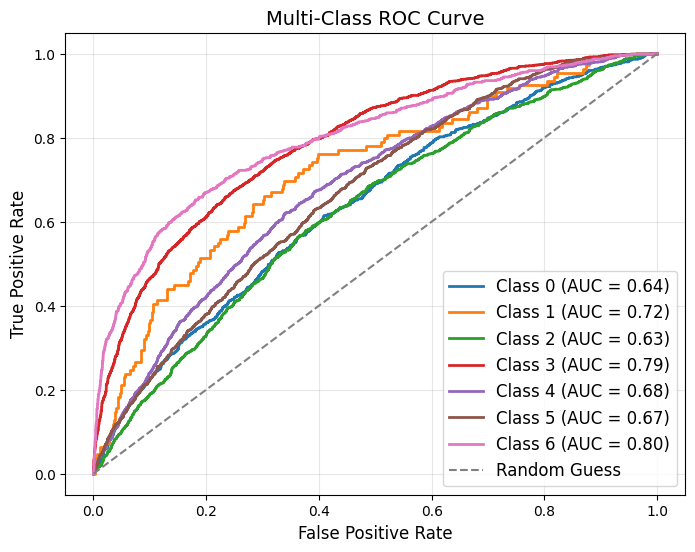

In [24]:
# Plot ROC curve for each class
n_classes = 7

plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(ex_fpr1[i], ex_tpr1[i], lw=2, label=f"Class {i} (AUC = {ex_roc_auc1[i]:.2f})")

plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label="Random Guess")
plt.xlabel("False Positive Rate", fontsize=12)
plt.ylabel("True Positive Rate", fontsize=12)
plt.title("Multi-Class ROC Curve", fontsize=14)
plt.legend(loc="lower right", fontsize=12)
plt.grid(alpha=0.3)
plt.show()